In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from mpmath import mp, matrix, eye
import math

In [47]:
def set_precision(dps):
    mp.dps = dps

def rand_matrix(n: int, scale: float = 1.0):
    return matrix([[mp.rand() * scale for _ in range(n)] for _ in range(n)])

def symmetrize(A):
    return (A + A.T) * mp.mpf('0.5')

def eigh_mp(A):
    vals, vecs = mp.eigh(A)
    Q = matrix(vecs)
    lam = list(vals)
    return Q, lam

def project_onto_A(A, tol=None):
    
    Q, lam = eigh_mp(A)
    if tol is None:
        tol = mp.mpf('0')
    tol_im = mp.mpf(f'1e-{mp.dps}')  # imag-part tolerance for sanity check
    lam_real = [mp.mpf(mp.re(lv)) if abs(mp.im(lv)) < tol_im else
            (_ for _ in ()).throw(ValueError(f"eig has non-negligible imag {lv}"))
            for lv in lam]
    lam_clipped = [lv if lv > tol else mp.mpf('0') for lv in lam_real]
    n = A.rows
    D = matrix(n)
    for i, v in enumerate(lam_clipped):
        D[i, i] = v
    return Q * D * Q.T

def project_onto_B(A):
    S = symmetrize(A)
    n = S.rows
    for i in range(n):
        S[i, i] = mp.mpf('1')
    return S

def fro_norm(A):
    return mp.sqrt(mp.fsum(A[i, j]**2 for i in range(A.rows) for j in range(A.cols)))

def is_psd(A, tol=mp.mpf('0')):
    """
    Return (ok, lam_min) where:
      ok       : True iff λ_min(A_sym) >= -tol
      lam_min  : smallest eigenvalue of the symmetrized matrix
    tol = 0 enforces the exact (theoretical) PSD test; increase tol to be pragmatic.
    """
    vals, _ = mp.eigh(A)          # real for symmetric S
    lam_min = min(vals)
    return (lam_min >= -tol), lam_min

def is_psd_boundary(A, tol=mp.mpf('0')):
    """
    Return (ok, lam_min) where:
      ok       : True iff A is PSD and λ_min(A) is (numerically) zero,
      lam_min  : smallest eigenvalue of the symmetrized matrix.
    tol = 0 enforces the exact (theoretical) boundary test; increase tol
    to allow for numerical tolerance.
    """

    vals, _ = mp.eigh(A)
    lam_min = min(vals)

    # PSD if all eigenvalues >= -tol
    psd = all(lv >= -tol for lv in vals)

    # On the boundary if PSD and min eigenvalue is within tol of 0
    on_boundary = psd and abs(lam_min) <= tol

    return on_boundary, lam_min


def is_S1(A, tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check if A is (approximately) symmetric with diag=1.
    """
    sym_err  = fro_norm(A - A.T) * mp.mpf('0.5')     # = ||skew(A)||_F
    if A.rows > 0:
        diag_err = max(abs(A[i,i] - mp.mpf('1')) for i in range(A.rows))
    else:
        diag_err = mp.mpf('0')
    ok = (sym_err <= tol_sym) and (diag_err <= tol_diag)
    return ok, {'sym_err': sym_err, 'diag_err': diag_err}

def is_S11(A, tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check if A is approximately symmetric (within tol_sym)
    and satisfies X[0,0] = 1 (within tol_diag).
    """
    sym_err = fro_norm(A - A.T)           # uses your existing fro_norm
    x11_err = abs(A[0, 0] - mp.mpf('1')) if A.rows and A.cols else mp.mpf('0')

    ok = (sym_err <= tol_sym) and (x11_err <= tol_diag)
    return ok, {'sym_err': sym_err, 'x11_err': x11_err}




def is_feasible_setting1(A, tol_psd=mp.mpf('0'), tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check feasibility: PSD and in S1 (symmetric + diag=1).
    """
    ok_psd, lam_min = is_psd(A, tol=tol_psd)
    ok_s1, d        = is_S1(A, tol_sym=tol_sym, tol_diag=tol_diag)
    ok = ok_psd and ok_s1
    diags = {'lam_min': lam_min, **d}
    return ok, diags

def is_feasible_setting2(A, tol_psd=mp.mpf('0'), tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check feasibility: PSDb and in S1 (symmetric + diag=1).
    """
    ok_psd, lam_min = is_psd_boundary(A, tol=tol_psd)
    ok_s1, d        = is_S1(A, tol_sym=tol_sym, tol_diag=tol_diag)
    ok = ok_psd and ok_s1
    diags = {'lam_min': lam_min, **d}
    return ok, diags

def is_feasible_setting3(A, tol_psd=mp.mpf('0'), tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check feasibility: PSDb and in S1 (symmetric + entry1=1).
    """
    ok_psd, lam_min = is_psd_boundary(A, tol=tol_psd)
    ok_s1, d        = is_S11(A, tol_sym=tol_sym, tol_diag=tol_diag)
    ok = ok_psd and ok_s1
    diags = {'lam_min': lam_min, **d}
    return ok, diags

def vec_inner(u, v):
    """Inner product <u,v> treating matrices as flattened vectors."""
    return mp.fsum(u[i,j]*v[i,j] for i in range(u.rows) for j in range(u.cols))

def vec_norm2(u):
    """Squared Frobenius norm."""
    return mp.fsum(u[i,j]**2 for i in range(u.rows) for j in range(u.cols))


In [50]:
def project_onto_A(A, tol=None):
    # Eigendecomposition (assumes A is Hermitian / symmetric)
    Q, lam = eigh_mp(A)

    # Tolerances (use exact mpf types)
    if tol is None:
        tol = mp.mpf('0')              # treat exact zeros as semidefinite
    tol_im = mp.mpf(f'1e-{mp.dps}')  # imag-part tolerance for sanity check

    # Real-part extraction with sanity check
    lam_real = [mp.mpf(mp.re(lv)) if abs(mp.im(lv)) < tol_im
                else (_ for _ in ()).throw(ValueError(f"eig has non-negligible imag {lv}"))
                for lv in lam]

    # If any eigenvalue is <= tol, do standard PSD clipping; else (PD) push to boundary
    if any(lv <= tol for lv in lam_real):
        lam_mod = [lv if lv > tol else mp.mpf('0') for lv in lam_real]
    else:
        # Already PD: zero the smallest eigenvalue (force rank drop)
        k_min = min(range(len(lam_real)), key=lambda i: lam_real[i])
        lam_mod = lam_real[:]
        lam_mod[k_min] = mp.mpf('0')
    # Reassemble
    D = matrix(len(lam_mod))
    for i, v in enumerate(lam_mod):
        D[i, i] = v

    # If A is real-symmetric, Q.T is fine; for complex Hermitian, use Q.conjugate().T
    return Q * D * Q.T

In [4]:
def project_onto_B(A):
    S = symmetrize(A)
    S[0, 0] = mp.mpf('1')
    return S

In [5]:
def douglas_rachford(M, max_iterates, ignore_tol=False, tol_stop=mp.mpf('1e-6')):
    """
    High-precision Douglas–Rachford using existing project_onto_A and project_onto_B.
    
    Args:
        M            : starting matrix (mpmath.matrix)
        max_iterates : maximum number of iterations
        ignore_tol   : if True, ignore stopping tolerance
        tol_stop     : tolerance for stopping based on successive P_B iterates
        
    Returns:
        (last_proj, tol, iters, Xi, Proj_Xi)
    """
    Xi = [M]
    Proj_Xi = [project_onto_B(M)]
    iterates = 0
    
    while iterates < max_iterates:
        Xk = Xi[-1]

        PB = project_onto_B(Xk)
        RB = PB*2 - Xk

        PARB = project_onto_A(RB)
        RARB = PARB*2 - RB

        # relaxation 1/2: X_{k+1} = 0.5*R_A R_B X_k + 0.5*X_k
        X_next = (RARB + Xk) * mp.mpf('0.5')
        Xi.append(X_next)

        PB_next = project_onto_B(X_next)
        Proj_Xi.append(PB_next)

        iterates += 1
        tol = fro_norm(PB_next - Proj_Xi[-2])

        if (not ignore_tol) and (tol < tol_stop):
            break
    
    return Proj_Xi[-1], tol, iterates, Xi, Proj_Xi


In [6]:
def TTx(M):
    """
    Do two Douglas–Rachford updates in high precision (mpmath).
    Returns the initial matrix and the next two iterates.
    """
    Xi = [M]  # initial point
    for _ in range(2):
        PB   = project_onto_B(Xi[-1])
        RB   = PB*2 - Xi[-1]
        PARB = project_onto_A(RB)
        RARB = PARB*2 - RB
        T    = (RARB + Xi[-1]) * mp.mpf('0.5')   # high-precision 1/2
        Xi.append(T)
    return Xi[0], Xi[1], Xi[2]


In [28]:
def lyapunov_surrogate(x, max_iterates, ignore_tol=False):
    iterates = 0
    Xi = [x]
    Proj_Xi = [project_onto_B(x)]

    stopping_threshold = mp.mpf('1e-6') if not ignore_tol else mp.mpf('1e-30')
    iterate_increment  = 2 if not ignore_tol else 1

    while iterates < max_iterates:
        ttx = TTx(Xi[-1])   # returns (x, T(x), TT(x))
        w1  = ttx[1] - ttx[0]
        w2  = ttx[2] - ttx[0]

        w1_norm_sq = vec_norm2(w1)
        w2_norm_sq = vec_norm2(w2)
        product    = vec_inner(w1, w2)

        # Fixed point test
        if fro_norm(w2) < mp.mpf('1e-15') and not ignore_tol:
            Xi.append(ttx[2])
            Proj_Xi.append(project_onto_B(Xi[-1]))
            tol = fro_norm(ttx[2]-ttx[1])
            iterates += iterate_increment
            break
        
        if fro_norm(w2) == mp.mpf('0') and ignore_tol:
            Xi.append(ttx[1])
            Proj_Xi.append(project_onto_B(Xi[-1]))
            tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
            iterates += 1
            print("dr update: denominator is zero")
            continue
        
        collinear = mp.mpf('1') - (product**2) / (w1_norm_sq * w2_norm_sq)

        if collinear > mp.mpf('1e-15') or ignore_tol:
            # Matrix and vector for mu
            Mmat = matrix([
                [w2_norm_sq, -product],
                [-product,   w1_norm_sq]
            ])
            Vvec = matrix([
                [w1_norm_sq],
                [w2_norm_sq - product + w1_norm_sq]
            ])
            denom = w1_norm_sq * w2_norm_sq - product**2
            print("LT denom is:", denom)
            if denom == mp.mpf('0'):
                Xi.append(ttx[1])
                Proj_Xi.append(project_onto_B(Xi[-1]))
                tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
                iterates += 1
                print("dr update: denominator is zero")
                continue
            mu    = (mp.mpf('1')/denom) * (Mmat * Vvec)

            # LT step
            LT = ttx[0] + mu[0] * w1 + mu[1] * w2
            Xi.append(LT)
            Proj_Xi.append(project_onto_B(Xi[-1]))

            tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
            iterates += iterate_increment
            print("lt update")
            if tol < stopping_threshold and not ignore_tol:
                break
        else:
            # Collinear points → just T(x)
            Xi.append(ttx[1])
            Proj_Xi.append(project_onto_B(Xi[-1]))
            print("dr update, collinear")
            tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
            iterates += 1

            if tol < stopping_threshold and not ignore_tol:
                break

    return Proj_Xi[-1], tol, iterates, Xi, Proj_Xi


In [ ]:
def projected_lyapunov_surrogate(x, max_iterates, ignore_tol=False,
                                 tol_threshold=mp.mpf('1e-6')):
    """
    mpmath-precision 'projected' Lyapunov Surrogate:
      - maintains both P_A(X_k) and P_B(X_k)
      - uses TTx on the latest A-projection

    Assumes the following are already defined for mpmath.matrices:
      project_onto_A, project_onto_B, TTx
    """
    

    stopping_threshold = (tol_threshold if not ignore_tol else mp.mpf('1e-40'))
    iterate_increment  = (2 if not ignore_tol else 1)

    iterates = 0
    Xi      = [x]
    ProjB   = [project_onto_B(x)]  # P_A(X_0)
    ProjA   = [project_onto_B(x)]  # P_B(X_0)

    while iterates < max_iterates:
        # Use TTx on the latest A-projection (as per your docstring)
        XA         = ProjA[-1]
        x0, x1, x2 = TTx(XA)  # all mpmath.matrices

        # w1 = T(x) - x, w2 = TT(x) - x
        w1 = x1 - x0
        w2 = x2 - x0

        # norms / inner products
        w1_ns = vec_norm2(w1)              # ||w1||_F^2
        w2_ns = vec_norm2(w2)              # ||w2||_F^2
        prod  = vec_inner(w1, w2)          # <w1, w2>_F

        # fixed-point checks on w2
        norm_w2 = fro_norm(w2)
        if (not ignore_tol and norm_w2 < mp.mpf('1e-15')):
            Xi.append(x2)
            ProjA.append(project_onto_B(Xi[-1]))
            ProjB.append(project_onto_B(Xi[-1]))
            tol = fro_norm(x2 - x1)
            iterates += iterate_increment
            print("dr update: denominator is zero")
            if (not ignore_tol) and (tol <= stopping_threshold):
                break
            continue
        
        if norm_w2 == mp.mpf('0') and ignore_tol:
            Xi.append(x1)
            ProjB.append(project_onto_B(Xi[-1]))
            tol = fro_norm(ProjB[-1]-ProjB[-2])
            iterates += 1
            print("dr update: denominator is zero")
            continue

        # Collinearity measure: 1 - (prod^2)/(||w1||^2 ||w2||^2)
        collinear = mp.mpf('1') - (prod*prod) / (w1_ns * w2_ns)

        if collinear > mp.mpf('1e-15') or ignore_tol:
            # Closed-form 2x2 solve for (mu1, mu2)
            a   = w2_ns
            b   = w1_ns
            c   = prod
            den = a*b - c*c
            print("PLT denom is:", den)
            if den == mp.mpf('0'):
                Xi.append(x1)
                ProjB.append(project_onto_B(Xi[-1]))
                tol = fro_norm(ProjB[-1]-ProjB[-2])
                iterates += 1
                print("dr update: denominator is zero")
                continue
            v1  = b
            v2  = (a - c + b)
            mu1 = (a*v1 + (-c)*v2) / den
            mu2 = ((-c)*v1 + b*v2) / den

            # LT = x + mu1*w1 + mu2*w2
            LT = x0 + mu1*w1 + mu2*w2

            Xi.append(LT)
            ProjA.append(project_onto_B(LT))
            ProjB.append(project_onto_B(LT))

            tol = fro_norm(ProjA[-1] - ProjA[-2])   # stopping on A-shadow
            iterates += iterate_increment
            print("plt update")
            if (not ignore_tol) and (tol <= stopping_threshold):
                break
        else:
            # Collinear → take T(x)
            Xi.append(x1)
            ProjA.append(project_onto_B(Xi[-1]))
            ProjB.append(project_onto_B(Xi[-1]))
            tol = fro_norm(ProjA[-1] - ProjA[-2])   # stopping on A-shadow
            iterates += 1
            print("dr update: collinear")
            if (not ignore_tol) and (tol <= stopping_threshold):
                break

    # Return: P_A(last), tol, iter count, raw iterates, A-shadow sequence
    return ProjA[-1], tol, iterates, Xi, ProjA


In [9]:

def Repeated(Zi_list, max_iterates, exp):
    # Clamp exp to available starts
    exp = min(exp, len(Zi_list))

    def DR_repeated(Zi_list, max_iterates, exp):
        DR_list, tolerance, num_it, T_DR, Validity = [], [], [], [], []
        for i in range(exp):
            Zi = Zi_list[i]
            t0 = time.perf_counter()
            Proj_B, tol, iters, *_ = douglas_rachford(Zi, max_iterates)
            T_DR.append(time.perf_counter() - t0)
            DR_list.append(Proj_B)
            tolerance.append(tol)
            num_it.append(iters)
            Validity.append(is_feasible(Proj_B))
        return DR_list, tolerance, num_it, T_DR, Validity

    def LT_repeated(Zi_list, max_iterates, exp):
        LT_list, tolerance, num_it, T_LT, Validity = [], [], [], [], []
        for i in range(exp):
            Zi = Zi_list[i]
            t0 = time.perf_counter()
            Proj_B, tol, iters, *_ = lyapunov_surrogate(Zi, max_iterates)
            T_LT.append(time.perf_counter() - t0)
            LT_list.append(Proj_B)
            tolerance.append(tol)
            num_it.append(iters)
            Validity.append(is_feasible(Proj_B))
        return LT_list, tolerance, num_it, T_LT, Validity

    def PLT_repeated(Zi_list, max_iterates, exp):
        PLT_list, tolerance, num_it, T_PLT, Validity = [], [], [], [], []
        for i in range(exp):
            Zi = Zi_list[i]
            t0 = time.perf_counter()
            Proj_B, tol, iters, *_ = projected_lyapunov_surrogate(Zi, max_iterates)
            T_PLT.append(time.perf_counter() - t0)
            PLT_list.append(Proj_B)
            tolerance.append(tol)
            num_it.append(iters)
            Validity.append(is_feasible(Proj_B))
        return PLT_list, tolerance, num_it, T_PLT, Validity

    DR  = DR_repeated(Zi_list, max_iterates, exp)
    LT  = LT_repeated(Zi_list, max_iterates, exp)
    PLT = PLT_repeated(Zi_list, max_iterates, exp)
    return DR, LT, PLT


In [10]:
def count_true(lst):
    return sum(1 for item in lst if item)

In [11]:
def uniform01_fixed(rng, bits=64):
    # exact rational in [0,1)
    num = rng.getrandbits(bits)
    den = 1 << bits
    return mp.mpf(num) / den  # value is independent of mp.dps

def uniform_ab(rng, a, b, bits=64):
    u = uniform01_fixed(rng, bits)
    return a + (b - a) * u


def rand_matrix_fixed(n, rng, a=-1, b=1, bits=64):
    M = matrix(n, n)
    for i in range(n):
        for j in range(n):
            M[i, j] = uniform_ab(rng, a, b, bits)
    return M



In [13]:
precision=300
set_precision(precision)
master_seed = 1  # change to get a different reproducible stream
rng = random.Random(master_seed)

exp = 10
n   = 2
M_list = []
for _ in range(exp):
    A = rand_matrix_fixed(n, rng, a=-1,b=1, bits=128)
    M = symmetrize(A)
    M_list.append(M)
M_list[0]

matrix(
[['0.6045301188004360246985081256570440523483665519045405589526966598850273732993431701127941269025001247428008355200290679931640625', '-0.40983605880649758187571670457502657506819471223697638530722275536523017279123159672103195172443435012610279954969882965087890625'],
 ['-0.40983605880649758187571670457502657506819471223697638530722275536523017279123159672103195172443435012610279954969882965087890625', '-0.5800903822347878689030705744512932189634221351806010043737648239265478820376841420495585277539163371329777874052524566650390625']])

In [14]:
def round_matrix(M, ndigits=None, tol_im=None):
    """
    Convert an mpmath matrix (possibly complex) to a NumPy float64 array.
    - Checks imaginary parts against tol_im, then discards them.
    - Optional decimal rounding via Python's round (post float conversion).
    """
    if tol_im is None:
        tol_im = mp.mpf(f'1e-{mp.dps//2}')  # precision-aware default

    rows, cols = M.rows, M.cols
    A = np.empty((rows, cols), dtype=np.float64)

    for i in range(rows):
        for j in range(cols):
            v = M[i, j]
            re, im = mp.re(v), mp.im(v)
            if abs(im) > tol_im:
                raise ValueError(f"Unexpected imaginary part at ({i},{j}): {im}")
            x = float(re)  # may lose precision if re is very large/small
            if ndigits is not None:
                x = round(x, ndigits)
            A[i, j] = x
    return A

def round_vector(v, ndigits=6, tol=None):
    """Convert list/tuple of mpc/mpf values to rounded mpf with imag discarded."""
    if tol is None:
        tol = mp.eps * 10
    out = []
    for x in v:
        re, im = mp.re(x), mp.im(x)
        if abs(im) > tol:
            raise ValueError(f"Unexpected imaginary part: {im}")
        out.append(mp.mpf(mp.nstr(re, n=ndigits)))
    return out

# Example usage
rounded = round_matrix(project_onto_A(M), ndigits=6)

mp.mpf(f'1e-{mp.dps}')
print(rounded)


[[ 0.718352 -0.106409]
 [-0.106409  0.015762]]


In [15]:

random.seed(1)  # mpmath uses Python’s RNG internally

exp = 10
n   = 10
M_list = []
for _ in range(exp):
    A = rand_matrix(n, scale=4.0)
    M = symmetrize(A)
    M_list.append(M)
M=M_list[0]

In [16]:
DR_X = douglas_rachford(M,300)
DR_X[2], is_feasible_setting1(DR_X[0]), round_matrix(DR_X[0],ndigits=6)

(8,
 (False,
  {'lam_min': mpf('5.59492418271135349767173849637800886815761745482553098338794283057036629280967889848323745465465491310358143864112420678012212400855314203648692634112683894272780227326230029738312712406745258841074807482900881264190501228767464121122783805520530862216086223755640698237524042970970895014254472531002629e-302'),
   'sym_err': mpf('0.0'),
   'diag_err': mpf('3.61142486137305304107241577717304211988544260806538699172817203959780634347362778190285102938424873281872699273691350932113489781734546944898896402568502549578537815640658257151044248235519009909767508455105813803171671200950697018633604842299823263001651273437046379543449911153581080897200966029437067')}),
 array([[1.      , 0.84954 , 1.077193, 0.963339, 0.904191, 0.849577,
         1.060389, 0.853149, 0.777726, 1.021916],
        [0.84954 , 2.420141, 1.808578, 1.97128 , 2.399109, 1.782609,
         2.830984, 1.849076, 1.028511, 1.149223],
        [1.077193, 1.808578, 3.079713, 2.29847 , 2.241432, 2.

In [17]:
LT_X = lyapunov_surrogate(M,300)
LT_X[2],is_feasible(LT_X[0])

LT denom is: 38.9328197108677010619221943688526542269475994417897101390452381028009243688608741396526181409963016783326129972831268020731446460901047484030385333718322345851976634394669536699272068974869008495682984599094716168967540697518677097176821711415944371124004208199902716131435110836752585258693218578512
lt update
LT denom is: 0.0824189652381712830299075250969492936136951855541520623405572517702089607006492319929199954708959874528146769525151288379611867327109252312971435270184180137065731499918056490202338544816837051421142063817443967096061553674349753695787169711627529026636118333352737052459908509259961976340465847320394
lt update
LT denom is: 0.208216268040647289075809106626102423726119016648065983775192342427714896481903791630324347351566861771290736050822041500924627443497352111029287819611438799183248157128265326481923180235568923280357957802148991679403932709364198462096096990393285598832294778368962725394005650788886991045480318497405
lt update
LT denom is: 0.0052654

NameError: name 'is_feasible' is not defined

In [ ]:
PLT_X = projected_lyapunov_surrogate(M,300)
PLT_X[2],is_feasible(PLT_X[0])

(15,
 (False,
  {'lam_min': mpf('0.0068492841661374966082260380153587069542054651366904852002242180848056107893930465197101531441016550569049710869207503622927723663307'),
   'sym_err': mpf('1.4747002923280286723017426331308526109919256810060051398105072244653713624700571979904026847932485160456947075605354655489454747732e-129'),
   'diag_err': mpf('2.5967752362522381883384492769522344043949226087658940098725159818008353660165647926750883540878542789945392223125688886533929055624e-128')}),
 matrix(
 [['0.99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999', '0.53953897958197316096544157536712829711139343963711897121985316855222770082125700937315942109445644441130170255529984896610941469', '0.53484964206370113219310773691787321394013360414075460057412816516309014933595343677358795437602250004683069804265564062839943317', '0.4721238260540048503248631772555358333688522207982613747189446132908397974259165703978815

In [20]:
def lyapunov_surrogate(x, max_iterates):
    iterates = 0
    Xi = [x]
    Proj_Xi = [project_onto_B(x)]
    iterate_increment  = 1

    while iterates < max_iterates:
        ttx = TTx(Xi[-1])   # returns (x, T(x), TT(x))
        w1  = ttx[1] - ttx[0]
        w2  = ttx[2] - ttx[0]

        w1_norm_sq = vec_norm2(w1)
        w2_norm_sq = vec_norm2(w2)
        product    = vec_inner(w1, w2)
        
        
        Mmat = matrix([
            [w2_norm_sq, -product],
            [-product,   w1_norm_sq]
        ])
        Vvec = matrix([
            [w1_norm_sq],
            [w2_norm_sq - product + w1_norm_sq]
        ])
        denom = w1_norm_sq * w2_norm_sq - product**2
        print("LT denom is:", denom)

        mu    = (mp.mpf('1')/denom) * (Mmat * Vvec)

        # LT step
        LT = ttx[0] + mu[0] * w1 + mu[1] * w2
        Xi.append(LT)
        Proj_Xi.append(project_onto_B(Xi[-1]))

        tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
        iterates += iterate_increment
        print("lt update")
            

    return Proj_Xi[-1], tol, iterates, Xi, Proj_Xi


In [14]:
def douglas_rachford(M, max_iterates, ignore_tol=False, tol_stop=mp.mpf('1e-6')):
    """
    High-precision Douglas–Rachford using existing project_onto_A and project_onto_B.
    
    Args:
        M            : starting matrix (mpmath.matrix)
        max_iterates : maximum number of iterations
        ignore_tol   : if True, ignore stopping tolerance
        tol_stop     : tolerance for stopping based on successive P_B iterates
        
    Returns:
        (last_proj, tol, iters, Xi, Proj_Xi)
    """
    Xi = [M]
    Proj_Xi = [project_onto_B(M)]
    iterates = 0
    
    while iterates < max_iterates:
        Xk = Xi[-1]

        PB = project_onto_B(Xk)
        RB = PB*2 - Xk

        PARB = project_onto_A(RB)
        RARB = PARB*2 - RB

        # relaxation 1/2: X_{k+1} = 0.5*R_A R_B X_k + 0.5*X_k
        X_next = (RARB + Xk) * 0.5
        Xi.append(X_next)

        PB_next = project_onto_B(X_next)
        Proj_Xi.append(PB_next)

        iterates += 1
        tol = fro_norm(PB_next - Proj_Xi[-2])
    
    return Proj_Xi[-1], tol, iterates, Xi, Proj_Xi


In [52]:
precision=500
set_precision(precision)


def calculate_log_norms(iterates, threshold=None):
    """
    High-precision: return [ log10(||x_i - x_*||_F) ] for i = 1..k-1.
    Each entry is mp.mpf (or None if the norm is zero or below cutoff).
    threshold: cutoff on log10(norm); default ~half of working digits.
    """
    if len(iterates) < 2:
        return []

    if threshold is None:
        threshold = mp.mpf(-(mp.dps // 2))  # precision-aware cutoff

    xk = iterates[-1]
    out = []
    for xi in iterates[:-1]:
        n = fro_norm(xi - xk)  # mp.mpf >= 0
        if n == mp.mpf('0'):
            out.append(None)
        else:
            lg10 = mp.log10(n)  # exact base-10, no division by ln(10)
            out.append(lg10 if lg10 > threshold else None)
    return out




master_seed = 1  # change to get a different reproducible stream
rng = random.Random(master_seed)

exp = 1000
n   = 10
M_list = []
for _ in range(exp):
    A = rand_matrix_fixed(n, rng, a=-1,b=1, bits=128)
    M = symmetrize(A)
    M_list.append(M)
x0=M_list[0]
# can get quadratic lt linear plt if n=10, a=-4,b=4 bound psd and s11

runs = 10
iterates_set1 = douglas_rachford(x0, runs, True)[3]
iterates_set2 = lyapunov_surrogate(x0, runs, True)[3]
iterates_set3 = projected_lyapunov_surrogate(x0, runs, True)[3]

log_norms_set1 = calculate_log_norms(iterates_set1)
log_norms_set2 = calculate_log_norms(iterates_set2)
log_norms_set3 = calculate_log_norms(iterates_set3)


LT denom is: 9.6167314987780958234484373314024976678939775614391926006094562904357190186504040976072426477151125412231923918918882566478008952716852051447362088871937009674059901782687275979139139881483829594449522572889378535073414259704722698230618015284099504468521295891450892746498219986234637857273334528975933648634754949554492923927053108944533208989552182318764023388700305485821147738803911695303249686837393391823136755842944809630594633006288803725079766241384787964976006282892590634159743105344439381
lt update
LT denom is: 0.0030485806019771437841351686905827521294980887941552088116094187853861320519059588796011695808424032716193366390373935688320602251467318848785107693667588465420963907775592799935642160760897886864462341170737786333800761399843380398676102667291693184921735141583839753694173833126100330845856089917591971812474900181175577981258769202468904012528828046809385035141452283391746873366353733048551886856424011638248290435037530011368255013105603926865591462809503

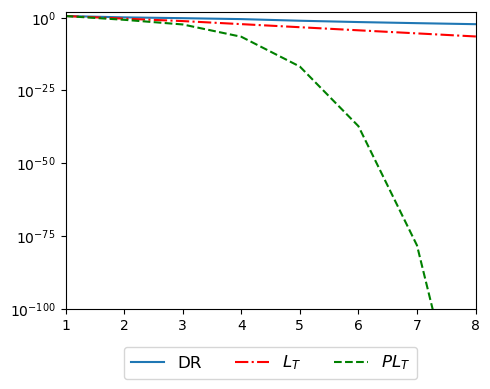

In [53]:
# Plotting
plt.figure(figsize=(5, 4))
plt.plot(range(1, len(log_norms_set1)+1), log_norms_set1,  label='DR')
plt.plot(range(1, len(log_norms_set2) + 1), log_norms_set2,  label='$L_T$',  linestyle='-.', color='red')
plt.plot(range(1, len(log_norms_set3) + 1), log_norms_set3,  label='$PL_T$', color='green', linestyle= '--')
plt.grid(False)
plt.ylim(-100,2)
plt.xlim(1, 8)

# Set y-ticks as powers of 10
ax = plt.gca()
ax.set_yticks([-100, -75, -50, -25, 0])
ax.set_yticklabels([r'$10^{-100}$', r'$10^{-75}$', r'$10^{-50}$', r'$10^{-25}$', r'$10^{0}$'])

#plt.xlabel('Iteration')
#plt.ylabel(r'$\log \|x_k - \bar{x}\|$')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=12
)

plt.tight_layout()  # Adjust layout to make space for legend
plt.savefig('convergence_plot.png', bbox_inches='tight')
plt.show()

In [44]:
ch=-1
round_matrix(iterates_set1[ch]), round_matrix(iterates_set2[ch]), round_matrix(iterates_set3[ch])

(array([[ 1.        , -0.52177401, -0.21175982,  0.10445373,  0.5600486 ,
         -0.12633388,  0.35603751,  0.24890864, -0.34010288, -0.24142315],
        [-0.52177401,  0.98958215,  0.58872272,  0.12083646, -0.19113183,
          0.41348313,  0.47060825, -0.01358358, -0.01452922,  0.31780341],
        [-0.21175982,  0.58872272,  0.69483355,  0.06942844,  0.09081381,
          0.32660566,  0.52222965,  0.2671826 ,  0.20863201,  0.23632211],
        [ 0.10445373,  0.12083646,  0.06942844,  0.19853921,  0.12454865,
         -0.15440321,  0.28548195,  0.23485908, -0.07530489,  0.02243388],
        [ 0.5600486 , -0.19113183,  0.09081381,  0.12454865,  0.52322615,
          0.06146203,  0.30857799,  0.30007415, -0.17917028, -0.08274427],
        [-0.12633388,  0.41348313,  0.32660566, -0.15440321,  0.06146203,
          0.70015101,  0.02234931, -0.27174693, -0.13028714,  0.129463  ],
        [ 0.35603751,  0.47060825,  0.52222965,  0.28548195,  0.30857799,
          0.02234931,  1.2012390

In [48]:
t='1e-6'
is_feasible_setting3(iterates_set1[ch],  tol_psd=mp.mpf(t), tol_sym=mp.mpf(t), tol_diag=mp.mpf(t))  # precision-aware tol

(True,
 {'lam_min': mpf('-8.05338519817710048654982389550876901072535678469691836792035488905080287529640853453548204302135173335039249167009762988832311538489194868627777221655516441774449067241721053607485145622145926070330981583459739855396709046237760832479658815766006065090412500887031904215526680888673618164430435021898686e-302'),
  'sym_err': mpf('6.36738323782507519888819431035342566423941138271777054568437918741688843880497830539497667268547388089505964458657327720873576535468347657824066783282588290457716339692082106999849815156791959370440284880296330831199504348545478878583587986333960957900773954785284635757042443128594090823930519460034602e-301'),
  'x11_err': mpf('9.33263618503218878990089544723817169617091446371708024621714339795966910975775634454440327097881102359594989930324242624215487521354032394841520817203930756234410666138325150273995075985901831511100490796265113118240512514795933790805178271125415103810698378854426481119469814228660959222017662910442798e-301')}

In [49]:
is_feasible_setting3(iterates_set2[ch],  tol_psd=mp.mpf(t), tol_sym=mp.mpf(t), tol_diag=mp.mpf(t))  # precision-aware tol

(True,
 {'lam_min': mpf('-0.00000000000000216682812142511800944723994239067127050980112809486925429035146964636908669856471796574726888161208557696723714040989234181239868708921504302993013541764622228538510270886495712054438503319295706192072767302218539517269855915805176002265687943700885982394999888186494378461559665841724874604363970601617'),
  'sym_err': mpf('1.04422715460266819778776049293789964687066693474396929201219194549457490942546939211100783264158324925178948862754746069551234351325906578643566930000105357417455096948665859895529829017579352741909135035587173444439966956276385970229424554675254023687949567494307900352240821903074824921292591307468272e-300'),
  'x11_err': mpf('1.026589980353540766889098499196198886578800591008878827083885773775563602073353197899884359807669212595554488923356666886637036273489435634325672898924323831857851732752157665301394583584492014662210539875891624430064563766275527169885696098237956614191768216739869129231416795651527055144219429201487

In [50]:
is_feasible_setting3(iterates_set3[ch],  tol_psd=mp.mpf(t), tol_sym=mp.mpf(t), tol_diag=mp.mpf(t))  # precision-aware tol


(True,
 {'lam_min': mpf('-8.09400569231352411472526691456180605243291107421139018263465874308323496682386899007926058831919006359394389737377844378149127052491072450223918348844685047136642133023100116464691962275206262537278584939393242439485876703229593554370329898907447882405699220455891161380118859530357261256626138816382145e-302'),
  'sym_err': mpf('3.3649930229890245880209542417326236018042025084923635063579504322668603964446858895382169701254322033582214916936948146219625764141343851003694072835262116795329898910708144159696439109762613871884167970851682781500679959250597361914278483314696987071643851132210254329000176690159903325633482682060734e-301'),
  'x11_err': mpf('1.58654815145547209428315222603048918834905545883190364185691437765314374865881857857254855606639787401131148288155121246116632878630185507123058538924668228559849813243515275546579162917603311356887083435365069230100887127515308744436880306091320567647818724405252501790309868418872363067743002694775276e-300')})

In [51]:
def calculate_norms(iterates, threshold=-precision):
    """
    Calculate log10 norms of iterates vs last iterate (mpmath safe).
    threshold: cutoff in base-10 (digits).
    """
    final_iterate = iterates[-1]
    norms = []
    for iterate in iterates[:-1]:
        diff = iterate - final_iterate
        norm = float(fro_norm(diff))  # mp.mpf, ≥ 0
        norms.append(norm)
    return norms




In [52]:
print("DR errors are:", calculate_norms(iterates_set1)),print("LT errors are:", calculate_norms(iterates_set2)), print("Projected LT errors are:", calculate_norms(iterates_set3))

DR errors are: [2.8197391208427804, 0.39229263921310087, 0.16951396852157946, 0.030361053737047342, 1.997327943238294e-299, 1.6165234483870632e-299, 1.2622233767761565e-299, 1.0290214139888045e-299, 6.455173869673347e-300, 4.738523703914455e-300]
LT errors are: [2.8062989579111903, 0.15825777263696805, 0.035233541317547, 3.720594765614423e-08]
Projected LT errors are: [2.8175983571628422, 0.14406072651825097, 1.863003818423257e-08, 4.596245212073462e-19, 5.023918688364647e-33, 8.32474201401667e-65, 2.2857416762107163e-128, 1.7232166165196181e-255, 1.1446733697718444e-299, 5.3926378603479614e-300]


(None, None, None)

In [157]:
def calculate_norms(iterates, threshold=-precision):
    """
    Calculate log10 ||x_i - x_{i-1}||_F for i = 1..k-1.
    Returns a list of length len(iterates)-1 with float values (or None when
    the norm is exactly zero or below the cutoff).
    
    threshold: cutoff on log10(norm). If None, use a precision-aware default
               of roughly half the working digits.
    """
    if len(iterates) < 2:
        return []

    if threshold is None:
        threshold = -(mp.dps // 2)  # e.g., mp.dps=200 -> cutoff ≈ 1e-100

    out = []
    for i in range(1, len(iterates)):
        diff = iterates[i] - iterates[i-1]
        n = fro_norm(diff)  # mp.mpf ≥ 0
        out.append(float(n))
    return out

In [158]:
print("DR errors are:", calculate_norms(iterates_set1)),print("LT errors are:", calculate_norms(iterates_set2)), print("Projected LT errors are:", calculate_norms(iterates_set3))

DR errors are: [6.48282328780067, 4.558079751158261, 4.030055458136032, 3.2644056163632365, 2.23606797749979, 2.2220376836101225, 1.4134362179293523, 1.5125357991529349e-128, 1.7315970844838767e-128, 8.251951759466194e-129, 1.2379766075065392e-128, 6.025118105258875e-129]
LT errors are: [9.14645100948696, 5.863058495232595, 3.649698652085038, 0.8341811748301475, 0.049198519047360584, 0.0025656325053948327, 0.000829876131988826, 3.029081329497213e-128, 4.11255180311335e-128, 3.3412514933319913e-128, 3.8396820611457124e-128, 7.349803398215093e-128]
Projected LT errors are: [10.625708927385585, 5.060402073754078, 1.3892744342593835, 0.20622375222223427, 3.402684959939321e-128, 3.4092699378784084e-128, 2.349050727829396e-128, 4.2690057950416595e-128, 4.0501211817197496e-128, 5.742721836233303e-128, 3.3048820224421957e-128, 4.963988499502228e-128]


(None, None, None)